In [1]:
import pandas as pd
import json
import csv
import ast
import os
import cv2
import matplotlib.pyplot as plt
import random


In [2]:
path = "C:\\Users\\rowanconverse\\OneDrive - University of New Mexico\\Dissertation\\1_Chapter\\consensus\\data\\expert\\"
consensus = pd.read_csv(path+"expertconsensus_superclass.csv")
rawlabels = pd.read_csv(path+"20230307_expertanalysislabels.csv")

In [3]:
subset = consensus.head(5)
subset

,label_id,filename,bbox,class_id
0,0,BDA_12C_20181127_1.JPG,"[4445.5, 2719.5, 95.0, 80.5]",2
1,1,BDA_12C_20181127_1.JPG,"[4312.5, 2739.5, 98.0, 44.0]",2
2,2,BDA_12C_20181127_1.JPG,"[3725.5, 1779.0, 73.5, 70.5]",2
3,3,BDA_12C_20181127_1.JPG,"[3628.0, 1882.0, 92.0, 38.0]",2
4,4,BDA_12C_20181127_1.JPG,"[3679.0, 1929.0, 65.0, 82.0]",2


In [ ]:
#From: https://towardsdatascience.com/tile-slice-yolo-dataset-for-small-objects-detection-a75bf26f7fa2

# get all image names
imnames = glob.glob('yolosample/ts/*.JPG')

# specify path for a new tiled dataset
newpath = 'sampletiled/ts/'
falsepath = 'sampletiled/false/'

# specify slice width=height
slice_size = 416

# tile all images in a loop

for imname in imnames:
    im = Image.open(imname)
    imr = np.array(im, dtype=np.uint8)
    height = imr.shape[0]
    width = imr.shape[1]
    labname = imname.replace('.JPG', '.txt')
    labels = pd.read_csv(labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
    
    # we need to rescale coordinates from 0-1 to real image height and width
    labels[['x1', 'w']] = labels[['x1', 'w']] * width
    labels[['y1', 'h']] = labels[['y1', 'h']] * height
    
    boxes = []
    
    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for row in labels.iterrows():
        x1 = row[1]['x1'] - row[1]['w']/2
        y1 = (height - row[1]['y1']) - row[1]['h']/2
        x2 = row[1]['x1'] + row[1]['w']/2
        y2 = (height - row[1]['y1']) + row[1]['h']/2

        boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
    
    counter = 0
    print('Image:', imname)
    # create tiles and find intersection with bounding boxes for each tile
    for i in range((height // slice_size)):
        for j in range((width // slice_size)):
            x1 = j*slice_size
            y1 = height - (i*slice_size)
            x2 = ((j+1)*slice_size) - 1
            y2 = (height - (i+1)*slice_size) + 1

            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            imsaved = False
            slice_labels = []

            for box in boxes:
                if pol.intersects(box[1]):
                    inter = pol.intersection(box[1])        
                    
                    if not imsaved:
                        sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                        sliced_im = Image.fromarray(sliced)
                        filename = imname.split('/')[-1]
                        slice_path = newpath + filename.replace('.JPG', f'_{i}_{j}.JPG')
                        
                        slice_labels_path = newpath + filename.replace('.JPG', f'_{i}_{j}.txt')
                        
                        print(slice_path)
                        sliced_im.save(slice_path)
                        imsaved = True                    
                    
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get central point for the new bounding box 
                    centre = new_box.centroid
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    # get bounding box width and height normalized to slice size
                    new_width = (max(x) - min(x)) / slice_size
                    new_height = (max(y) - min(y)) / slice_size
                    
                    # we have to normalize central x and invert y for yolo format
                    new_x = (centre.coords.xy[0][0] - x1) / slice_size
                    new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                    
                    counter += 1

                    slice_labels.append([box[0], new_x, new_y, new_width, new_height])
            
            # save txt with labels for the current tile
            if len(slice_labels) > 0:
                slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                print(slice_df)
                slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
            
            # if there are no bounding boxes intersect current tile, save this tile to a separate folder 
            if not imsaved:
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                sliced_im = Image.fromarray(sliced)
                filename = imname.split('/')[2]
                slice_path = falsepath + filename.replace('.JPG', f'_{i}_{j}.JPG')                

                sliced_im.save(slice_path)
                print('Slice without boxes saved')
                imsaved = True

In [11]:
#Coordinates aren't getting translated for some reason
def translate_labels(original_size, tile_size, labels):
    original_width, original_height = original_size
    tile_width, tile_height = tile_size
    num_columns = original_width // tile_width
    num_rows = original_height // tile_height
    
    tiled_labels = []
    for label in labels:
        label_id = label['label_id']
        filename = os.path.splitext(label['filename'])[0]  # Strip extension
        x, y, width, height = ast.literal_eval(label['bbox'])
        
        column = x // tile_width
        row = y // tile_height
        
        tile_x = x % tile_width
        tile_y = y % tile_height
        
        new_x = tile_x + column * tile_width
        new_y = tile_y + row * tile_height
        
        tile_column = int(column) + 1  # Convert to integer and add 1
        tile_row = int(row) + 1  # Convert to integer and add 1
        
        tile_name = f"{filename}_{str(tile_row).zfill(2)}_{str(tile_column).zfill(2)}.png"
        
        new_bbox = [new_x, new_y, width, height]
        tiled_label = {
            'label_id': label_id,
            'filename': filename,
            'bbox': new_bbox,
            'class_id': label['class_id'],
            'tile_name': tile_name,
            # Copy any additional label properties here if needed
        }
        tiled_labels.append(tiled_label)
    
    return tiled_labels

# Example usage
original_size = (5472, 3648)
tile_size = (684, 521)
labels = []

# Load labels from CSV file
with open(path+'expertconsensus_superclass.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label = {
            'label_id': row['label_id'],
            'filename': row['filename'],
            'bbox': row['bbox'],
            'class_id': row['class_id'],
        }
        labels.append(label)

tiled_labels = translate_labels(original_size, tile_size, labels)
print(json.dumps(tiled_labels, indent=4))


[
    {
        "label_id": "0",
        "filename": "BDA_12C_20181127_1",
        "bbox": [
            4445.5,
            2719.5,
            95.0,
            80.5
        ],
        "class_id": "2",
        "tile_name": "BDA_12C_20181127_1_07_06.png"
    },
    {
        "label_id": "1",
        "filename": "BDA_12C_20181127_1",
        "bbox": [
            4312.5,
            2739.5,
            98.0,
            44.0
        ],
        "class_id": "2",
        "tile_name": "BDA_12C_20181127_1_07_06.png"
    },
    {
        "label_id": "2",
        "filename": "BDA_12C_20181127_1",
        "bbox": [
            3725.5,
            1779.0,
            73.5,
            70.5
        ],
        "class_id": "2",
        "tile_name": "BDA_12C_20181127_1_06_04.png"
    },
    {
        "label_id": "3",
        "filename": "BDA_12C_20181127_1",
        "bbox": [
            3628.0,
            1882.0,
            92.0,
            38.0
        ],
        "class_id": "2",
        "tile

In [20]:
#Save translated coordinates
with open(path+'expertconsensus_tiles.json', 'w', encoding='utf-8') as f:
    json.dump(tiled_labels, f, ensure_ascii=False, indent=4)

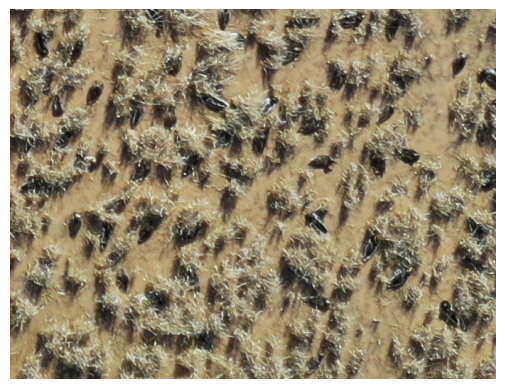

In [25]:
#Test by visualizing random tiles
def visualize_random_tile(tile_directory, json_file):
    # Select a random tiled image
    tiled_images = [file for file in os.listdir(tile_directory) if file.endswith('.png')]
    random_tile = random.choice(tiled_images)
    tile_path = os.path.join(tile_directory, random_tile)
    
    # Find corresponding labels from JSON data
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    
    tile_labels = [label for label in json_data if label['tile_name'] == os.path.splitext(random_tile)[0]]
    
    # Load and visualize the tile image with bounding boxes
    visualize_bboxes_on_tile(tile_path, tile_labels)

def visualize_bboxes_on_tile(tile_path, tile_labels):
    image = cv2.imread(tile_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.axis('off')
    
    for label in tile_labels:
        bbox = label['bbox']
        x, y, width, height = bbox
        class_id = label['class_id']
        
        # Draw bounding box
        plt.gca().add_patch(plt.Rectangle((x, y), width, height, fill=False, edgecolor='red', linewidth=2))
        
        # Add label text
        plt.text(x, y - 10, class_id, fontsize=10, color='red', weight='bold')
    
    plt.show()

# Example usage
tile_directory = 'C:\\Users\\rowanconverse\\OneDrive - University of New Mexico\Dissertation\\1_Chapter\\consensus\\data\\expert\\tiles\\'
json_file = 'C:\\Users\\rowanconverse\\OneDrive - University of New Mexico\Dissertation\\1_Chapter\\consensus\\data\\expert\\expertconsensus_tiles.json'

visualize_random_tile(tile_directory, json_file)